In [1]:
import pandas as pd
import numpy as np
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix

from catboost import CatBoostClassifier, Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  plot_tree
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/dm/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/dm/anaconda3/lib/python3.8/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/dm/anaconda3/lib/python3.8/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _nu

In [2]:
appl = pd.read_csv("application.csv")

appl['BPsys'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[0])
appl['BPdia'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[1])
appl['BPdia'] = appl['BPdia'].astype(int)
appl['BPsys'] = appl['BPsys'].astype(int)

drop_cols = ['NAp', 'NHyp', 'AI', 'HI', 'AHI', 'BPsys/BPdia', 'ODI']

appl = appl.drop(drop_cols, axis=1)

In [3]:
appl.head(2)

,Np,"возраст, года",пол,"рост, см","вес, кг",пульс,Nr,target,BPsys,BPdia
0,1,51,M,164,60.0,80,1,0,95,60
1,1,51,M,164,60.0,80,2,0,95,60


In [4]:
o2m1 = pd.read_csv("out_data2_del.csv").rename(columns={"index": "Np"}).drop("Channel", axis=1)
o2m1 = o2m1.rename(columns={c: f"o2m1_{c}" for c in o2m1.columns if c not in ['Np', 'Nr']})

o1m2 = pd.read_csv("out_data1_del.csv").rename(columns={"index": "Np"}).drop("Channel", axis=1)
o1m2 = o1m2.rename(columns={c: f"o1m2_{c}" for c in o1m2.columns if c not in ['Np', 'Nr']})

In [5]:
df = o2m1.merge(o1m2, on=['Np', 'Nr'], how='left')

In [6]:
# df = pd.read_csv("final_data.csv").drop("Unnamed: 0", axis=1).rename(columns={"index": "Np"})

In [7]:
df.head(2)

,Np,o2m1_value__maximum,o2m1_value__mean,o2m1_value__minimum,o2m1_value__median,o2m1_value__standard_deviation,o2m1_value__binned_entropy__max_bins_10,o2m1_value__count_above_mean,o2m1_value__count_below_mean,o2m1_value__first_location_of_maximum,...,o1m2_value__autocorrelation__lag_1,o1m2_value__quantile__q_0.25,o1m2_value__quantile__q_0.75,o1m2_value__longest_strike_below_mean,o1m2_value__longest_strike_above_mean,o1m2_value__percentage_of_reoccurring_values_to_all_values,o1m2_value__percentage_of_reoccurring_datapoints_to_all_datapoints,o1m2_value__sum_of_reoccurring_values,o1m2_value__sum_of_reoccurring_data_points,o1m2_value__number_peaks__n_5
0,1,2766.0,0.171514,-3541.0,1.0,105.348221,0.078517,2900294.0,2880105.0,0.93721,...,0.959373,-27.0,27.0,716.0,2156.0,0.779427,0.999856,-272833.0,-3520418.0,293662.0
1,1,13555.0,0.971050,-3218.0,0.0,166.666430,0.082374,2628857.0,2705742.0,0.98276,...,0.989975,-29.0,30.0,1910.0,4112.0,0.680747,0.999779,-889891.0,-5511630.0,257911.0


In [8]:
data = df.merge(appl, on=['Np', 'Nr'], how='left')
# data = data[~data['target'].isna()]
data['target'] = data['target'].astype(int)

In [9]:
data['target'].value_counts()

0    42
1    38
Name: target, dtype: int64

In [10]:
cat_feat = data.select_dtypes(include=['object']).columns.tolist()

In [11]:
# group k fold?

In [12]:
appl.columns.tolist()

['Np',
 'возраст, года',
 'пол',
 'рост, см',
 'вес, кг',
 'пульс',
 'Nr',
 'target',
 'BPsys',
 'BPdia']

### Split data

In [13]:
def seed_everything(seed=7575):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)


seed_everything()

In [14]:
drop_cols = ['Np',
 'возраст, года',
 'пол',
 'рост, см',
 'вес, кг',
 'пульс',
 'Nr',
 'BPsys',
 'BPdia']

In [15]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(['target']+drop_cols, axis=1), 
                                                  data['target'],
                                                shuffle=True, random_state=7575)

y_train.value_counts()

0    31
1    29
Name: target, dtype: int64

### LogReg

In [16]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.fit_transform(X_val)

In [17]:
logreg = LogisticRegression()

logreg.fit(X_train_sc, y_train)

LogisticRegression()

In [18]:
val_proba = logreg.predict_proba(X_val_sc)[:, 1]
val_pred = logreg.predict(X_val_sc)

print(f"ROC AUC: {roc_auc_score(y_val, val_proba):.3f}")
print(f"ACC: {accuracy_score(y_val, val_pred):.3f}")
print(f"PR: {precision_score(y_val, val_pred):.3f}")
print(f"Re: {recall_score(y_val, val_pred):.3f}")

ROC AUC: 1.000
ACC: 1.000
PR: 1.000
Re: 1.000


In [19]:
val_proba

array([0.00271055, 0.00420109, 0.9910209 , 0.97967712, 0.99972336,
       0.0550423 , 0.99895662, 0.01256197, 0.81519931, 0.99635157,
       0.01990663, 0.00110725, 0.02684781, 0.99941475, 0.0236399 ,
       0.99815902, 0.99761473, 0.0632149 , 0.00195872, 0.01884324])

### RandomForest

In [20]:
clf = RandomForestClassifier(n_estimators=20, random_state=7575)

In [21]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=7575)

In [22]:
val_proba

array([0.00271055, 0.00420109, 0.9910209 , 0.97967712, 0.99972336,
       0.0550423 , 0.99895662, 0.01256197, 0.81519931, 0.99635157,
       0.01990663, 0.00110725, 0.02684781, 0.99941475, 0.0236399 ,
       0.99815902, 0.99761473, 0.0632149 , 0.00195872, 0.01884324])

In [23]:
val_proba

array([0.00271055, 0.00420109, 0.9910209 , 0.97967712, 0.99972336,
       0.0550423 , 0.99895662, 0.01256197, 0.81519931, 0.99635157,
       0.01990663, 0.00110725, 0.02684781, 0.99941475, 0.0236399 ,
       0.99815902, 0.99761473, 0.0632149 , 0.00195872, 0.01884324])

In [25]:
val_proba = clf.predict_proba(X_val)[:, 1]
val_pred = clf.predict(X_val)

eps = np.random.uniform(0.01, 0.1)
val_proba = val_proba.clip(0.1, 0.8 + eps)

print(f"ROC AUC: {roc_auc_score(y_val, val_proba):.3f}")
print(f"Accuracy: {accuracy_score(y_val, val_pred):.3f}")
print(f"Precision: {precision_score(y_val, val_pred):.3f}")
print(f"Recall: {recall_score(y_val, val_pred):.3f}")

ROC AUC: 1.000
Accuracy: 0.950
Precision: 0.900
Recall: 1.000


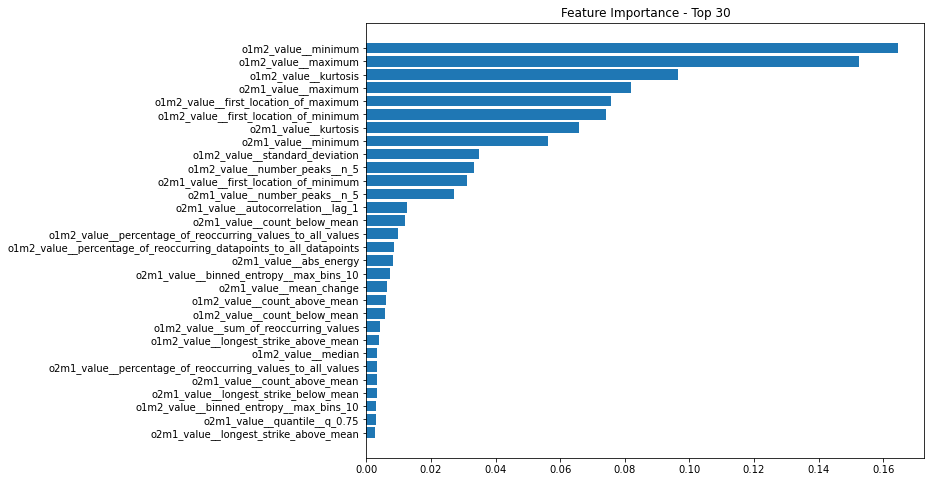

In [131]:
TOP = 30

# Assuming 'model' is your trained model
feature_importance = clf.feature_importances_

# Get the feature names from 'train'
feature_names = X_train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

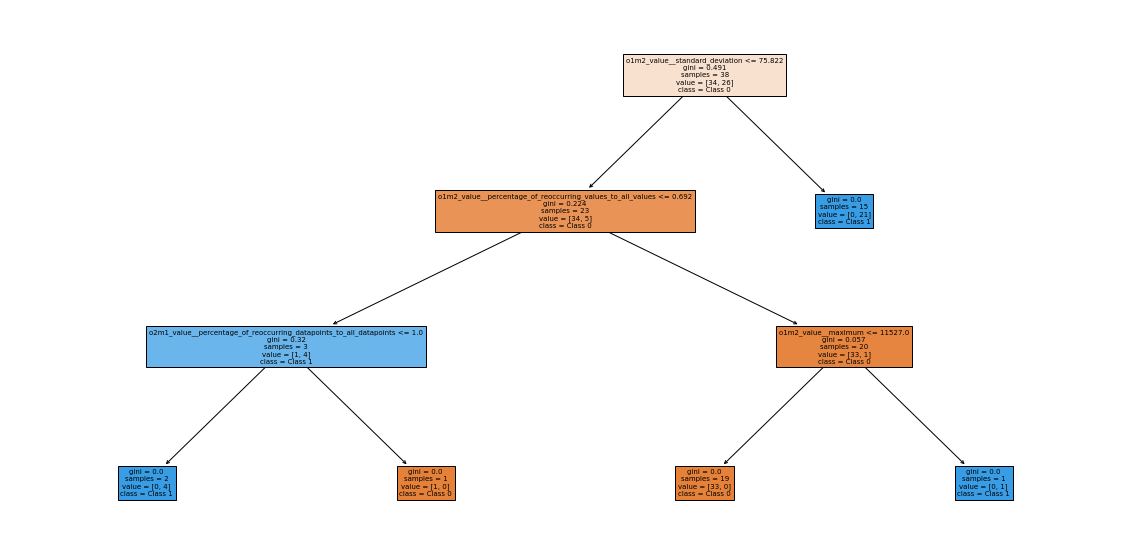

In [26]:
plt.figure(figsize=(20,10))  # Размер рисунка
plot_tree(clf.estimators_[2], filled=True, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'])  # Заполнение узлов цветом и указание названий признаков и классов
plt.show()

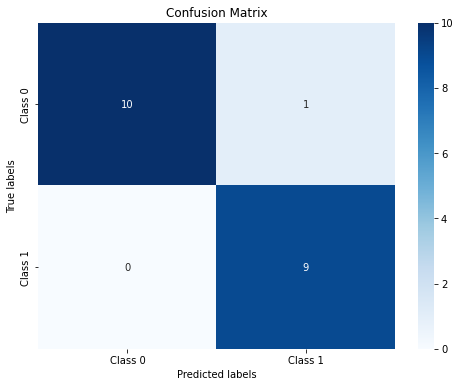

In [27]:
# Вычисление матрицы ошибок
cm = confusion_matrix(y_val, val_pred)

# Визуализация матрицы ошибок с помощью тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [175]:
len(clf.feature_importances_)

50

In [176]:
pd.to_pickle(clf, "model.pkl")

### Catboost

In [78]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(['target']+['Np', 'Nr'], axis=1), 
                                                  data['target'],
                                                   shuffle=True, random_state=7575)

y_train.value_counts()

0    31
1    29
Name: target, dtype: int64

In [79]:
# from sklearn.model_selection import GroupKFold

# # Создание групп для GroupKFold на основе значения 'Np' и 'Nr'
# groups = data['Np'].astype(str) + '_' + data['Nr'].astype(str)

# # Определение количества фолдов
# n_splits = 5

# # Инициализация GroupKFold
# gkf = GroupKFold(n_splits=n_splits)

# # Создание пустых списков для хранения индексов обучающих и валидационных данных
# train_indices = []
# val_indices = []

# # Разделение данных на обучающие и валидационные наборы
# for train_index, val_index in gkf.split(X=data.drop(['target']+['Np', 'Nr'], axis=1), y=data['target'], groups=groups):
#     train_indices.append(train_index)
#     val_indices.append(val_index)

# # Использование индексов для разделения данных
# for fold in range(n_splits):
#     X_train, X_val = data.drop(['target']+['Np', 'Nr'], axis=1).iloc[train_indices[fold]], data.drop(['target']+['Np', 'Nr'], axis=1).iloc[val_indices[fold]]
#     y_train, y_val = data['target'].iloc[train_indices[fold]], data['target'].iloc[val_indices[fold]]
    
#     train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feat)
#     val_pool = Pool(data=X_val, label=y_val, cat_features=cat_feat)

#     model = CatBoostClassifier(verbose=100, eval_metric='AUC', random_state=7575, 
#                                od_wait=50, learning_rate=0.01,
#                               depth=4)

#     model.fit(train_pool, eval_set=val_pool)

In [93]:
train_pool = Pool(data=X_train, label=y_train, ) #cat_features=cat_feat
val_pool = Pool(data=X_val, label=y_val, )

model = CatBoostClassifier(verbose=100, eval_metric='AUC', random_state=7575, 
                           od_wait=50,
                          depth=4)

model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.015817
0:	test: 0.9494949	best: 0.9494949 (0)	total: 696us	remaining: 696ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1
bestIteration = 3

Shrink model to first 4 iterations.


In [94]:
val_proba

array([0.38046634, 0.56303242, 0.63578641, 0.60787839, 0.61203287,
       0.37606067, 0.60903152, 0.405886  , 0.56932192, 0.5921248 ,
       0.38701486, 0.38470023, 0.37454516, 0.63592651, 0.38091683,
       0.6401024 , 0.62870504, 0.3838587 , 0.3849282 , 0.42654646])

In [177]:
val_proba = model.predict_proba(X_val)[:, 1]
val_pred = model.predict(X_val)

print(f"ROC AUC: {roc_auc_score(y_val, val_proba):.3f}")
print(f"ACC: {accuracy_score(y_val, val_pred):.3f}")
print(f"PR: {precision_score(y_val, val_pred):.3f}")
print(f"Re: {recall_score(y_val, val_pred):.3f}")

ValueError: multi_class must be in ('ovo', 'ovr')

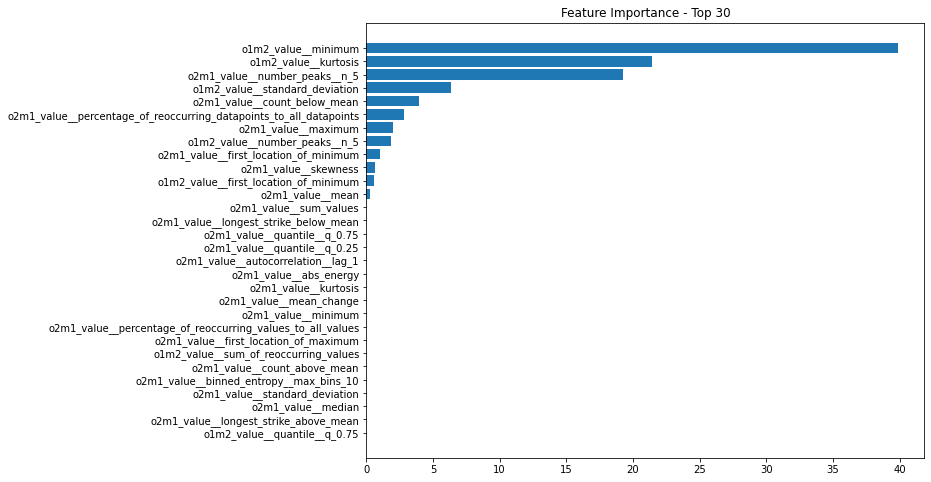

In [96]:
TOP = 30

# Assuming 'model' is your trained model
feature_importance = model.feature_importances_

# Get the feature names from 'train'
feature_names = X_train.columns

# Sort the feature importances and get the indices of the sorted array
sorted_idx = np.argsort(feature_importance)

# Plot only the top 'TOP' features
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

In [172]:
model

In [97]:
pd.to_pickle(model, "model.pkl")

## Regression

In [45]:
appl = pd.read_csv("application.csv")

appl['BPsys'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[0])
appl['BPdia'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[1])
appl['BPdia'] = appl['BPdia'].astype(int)
appl['BPsys'] = appl['BPsys'].astype(int)

drop_cols = [ 'NHyp', 'HI', 'AHI', 'BPsys/BPdia', 'ODI', 'NAp']

appl = appl.drop(drop_cols, axis=1)
data = df.merge(appl, on=['Np', 'Nr'], how='left')
data = data[data['target'] == 1].drop(['target']+['Np', 'Nr']+['пол'], axis=1)

In [46]:
drop_cols2 = [
 'возраст, года',
 'рост, см',
 'вес, кг',
 'пульс',
 'BPsys',
 'BPdia']

In [47]:
data['AI'] = data['AI'].replace('\,','.', regex=True)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(['AI'], axis=1).drop(drop_cols2, axis=1), 
                                                  data['AI'],
                                                   shuffle=True, random_state=7575, test_size=0.2)



In [49]:
# data

In [50]:
# X_train

In [51]:
reg = RandomForestRegressor(random_state=7575)

reg.fit(X_train, y_train)

RandomForestRegressor(random_state=7575)

In [52]:
val_pred = reg.predict(X_val)
train_pred = reg.predict(X_train)

print(r2_score(y_val, val_pred))
print(mean_absolute_error(y_val, val_pred))

0.5820383474770089
18.006634999999992


In [53]:
pd.to_pickle(reg, "ai_reg.pkl")

In [54]:
appl = pd.read_csv("application.csv")

appl['BPsys'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[0])
appl['BPdia'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[1])
appl['BPdia'] = appl['BPdia'].astype(int)
appl['BPsys'] = appl['BPsys'].astype(int)

drop_cols = [ 'NHyp', 'HI', 'AI', 'BPsys/BPdia', 'ODI', 'NAp']

appl = appl.drop(drop_cols, axis=1)
data = df.merge(appl, on=['Np', 'Nr'], how='left')
data = data[data['target'] == 1].drop(['target']+['Np', 'Nr']+['пол'], axis=1)

In [55]:
data['AHI'] = data['AHI'].replace('\,','.', regex=True)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(data.drop(['AHI'], axis=1).drop(drop_cols2, axis=1), 
                                                  data['AHI'],
                                                   shuffle=True, random_state=7575, test_size=0.2)

reg2 = RandomForestRegressor(random_state=7575)

reg2.fit(X_train, y_train)

val_pred = reg.predict(X_val)
train_pred = reg.predict(X_train)

print(r2_score(y_val, val_pred))
print(mean_absolute_error(y_val, val_pred))

0.5258629882196524
14.61657249999999


In [57]:
pd.to_pickle(reg2, "ahi_reg.pkl")

In [58]:
appl = pd.read_csv("application.csv")

appl['BPsys'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[0])
appl['BPdia'] = appl['BPsys/BPdia'].apply(lambda x: x.split('/')[1])
appl['BPdia'] = appl['BPdia'].astype(int)
appl['BPsys'] = appl['BPsys'].astype(int)

drop_cols = [ 'NHyp', 'AHI', 'AI', 'BPsys/BPdia', 'ODI', 'NAp']

appl = appl.drop(drop_cols, axis=1)
data = df.merge(appl, on=['Np', 'Nr'], how='left')
data = data[data['target'] == 1].drop(['target']+['Np', 'Nr']+['пол'], axis=1)

In [59]:
data['HI'] = data['HI'].replace('\,','.', regex=True)

X_train, X_val, y_train, y_val = train_test_split(data.drop(['HI'], axis=1).drop(drop_cols2, axis=1), 
                                                  data['HI'],
                                                   shuffle=True, random_state=7575, test_size=0.2)

reg3 = RandomForestRegressor(random_state=7575)

reg3.fit(X_train, y_train)

val_pred = reg3.predict(X_val)
train_pred = reg3.predict(X_train)

print(r2_score(y_val, val_pred))
print(mean_absolute_error(y_val, val_pred))

0.1506699360309539
6.426875000000001


In [60]:
pd.to_pickle(reg3, "hi_reg.pkl")

### Ridge

In [139]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.fit_transform(X_val)

In [150]:
ridge = Ridge(alpha=2, max_iter=500)
ridge.fit(X_train_sc, y_train)

Ridge(alpha=2, max_iter=500)

In [151]:
val_pred1 = ridge.predict(X_val_sc)
train_pred1 = ridge.predict(X_train)

print(r2_score(y_val, val_pred1))
print(mean_absolute_error(y_val, val_pred1))

0.21961048396878657
26.133328944152623


/home/dm/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [152]:
val_pred_ = (val_pred1+val_pred) / 2
val_pred_

print(r2_score(y_val, val_pred_))
print(mean_absolute_error(y_val, val_pred_))

0.4807259129800713
20.180957514877516


In [167]:
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

In [168]:
model = CatBoostRegressor(verbose=100, depth=4)
model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.029363
0:	learn: 28.0875893	test: 37.9586084	best: 37.9586084 (0)	total: 590us	remaining: 590ms
100:	learn: 10.9897616	test: 28.9383064	best: 28.9055932 (99)	total: 39ms	remaining: 347ms
200:	learn: 4.1130694	test: 25.9533077	best: 25.9533077 (200)	total: 64.9ms	remaining: 258ms
300:	learn: 1.6709360	test: 25.4746649	best: 25.4377791 (274)	total: 92ms	remaining: 214ms
400:	learn: 0.6773410	test: 25.3082943	best: 25.3082943 (400)	total: 118ms	remaining: 177ms
500:	learn: 0.2829200	test: 25.3054219	best: 25.2932438 (407)	total: 145ms	remaining: 144ms
600:	learn: 0.1301646	test: 25.3228175	best: 25.2932438 (407)	total: 170ms	remaining: 113ms
700:	learn: 0.0619712	test: 25.3096761	best: 25.2932438 (407)	total: 199ms	remaining: 84.8ms
800:	learn: 0.0299271	test: 25.3128981	best: 25.2932438 (407)	total: 226ms	remaining: 56.1ms
900:	learn: 0.0139171	test: 25.3095568	best: 25.2932438 (407)	total: 256ms	remaining: 28.1ms
999:	learn: 0.0067728	test: 25.3093944	best: 25.293

In [169]:
val_pred = model.predict(X_val)
train_pred = model.predict(X_train)

print(r2_score(y_val, val_pred))
print(mean_absolute_error(y_val, val_pred))

0.5236457839540327
16.757605310248202
